# Fine-tuning ResNet50

---

## 1. Load Tensors and Targets

The training, validation and test files and associated targets are loaded.

In [2]:
import numpy as np
from common import *

train_ids, train_targets = load_dataset('data/preprocess/train.npz')
valid_ids, valid_targets = load_dataset('data/preprocess/valid.npz')
test_ids, test_targets = load_dataset('data/preprocess/test.npz')

train_files = np.array(['data/train_photos/' + str(i) + '.jpg' for i in train_ids])
valid_files = np.array(['data/train_photos/' + str(i) + '.jpg' for i in valid_ids])
test_files = np.array(['data/train_photos/' + str(i) + '.jpg' for i in test_ids])

del train_ids, valid_ids, test_ids

print('There are %d images in the training dataset' % len(train_files))
print('There are %d images in the validation dataset' % len(valid_files))
print('There are %d images in the test dataset' % len(test_files))

There are 176131 images in the training dataset
There are 29355 images in the validation dataset
There are 29356 images in the test dataset


A fraction of the training (50000), validation (5000) and test (5000) datasets are loaded into tensors.

In [3]:
from keras.applications.resnet50 import preprocess_input

nb_train, nb_valid, nb_test = (50000,5000,5000)

train_tensors = preprocess_input(paths_to_tensor(train_files[:nb_train]))
del train_files
valid_tensors = preprocess_input(paths_to_tensor(valid_files[:nb_valid]))
del valid_files
test_tensors = preprocess_input(paths_to_tensor(test_files[:nb_test]))
del test_files

100%|██████████| 5000/5000 [00:21<00:00, 234.08it/s]


## 2. Import the ResNet50 Deep Learning Model

The pre-trained ResNet50 deep learning network is loaded. Note that the top layer is not included. The name of the layers composing the model are printed out to get an idea its architecture. This will be very informative later in this notebook when the model will be fine-tuned.

In [4]:
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)

for i, layer in enumerate(base_model.layers): print(i, layer.name)

0 input_1
1 conv1
2 bn_conv1
3 activation_1
4 max_pooling2d_1
5 res2a_branch2a
6 bn2a_branch2a
7 activation_2
8 res2a_branch2b
9 bn2a_branch2b
10 activation_3
11 res2a_branch2c
12 res2a_branch1
13 bn2a_branch2c
14 bn2a_branch1
15 add_1
16 activation_4
17 res2b_branch2a
18 bn2b_branch2a
19 activation_5
20 res2b_branch2b
21 bn2b_branch2b
22 activation_6
23 res2b_branch2c
24 bn2b_branch2c
25 add_2
26 activation_7
27 res2c_branch2a
28 bn2c_branch2a
29 activation_8
30 res2c_branch2b
31 bn2c_branch2b
32 activation_9
33 res2c_branch2c
34 bn2c_branch2c
35 add_3
36 activation_10
37 res3a_branch2a
38 bn3a_branch2a
39 activation_11
40 res3a_branch2b
41 bn3a_branch2b
42 activation_12
43 res3a_branch2c
44 res3a_branch1
45 bn3a_branch2c
46 bn3a_branch1
47 add_4
48 activation_13
49 res3b_branch2a
50 bn3b_branch2a
51 activation_14
52 res3b_branch2b
53 bn3b_branch2b
54 activation_15
55 res3b_branch2c
56 bn3b_branch2c
57 add_5
58 activation_16
59 res3c_branch2a
60 bn3c_branch2a
61 activation_17
62 res3c

In [5]:
for layer in base_model.layers: layer.trainable = False

## 3. Add New Layers

A simple CNN is built on top of ResNet50. It is made of a global average pooling layer, dropout layers and fully connected layers all equipped with a `relu` activation function. The top layer of this CNN is another fully connected layer with 9 nodes, i.e., the number of labels, and uses a `sigmoid` activation function to output probabilities. The dropout layers are used to prevent over-fitting (learning less is learning better).

The whole model is compiled and trained for a few epochs. Note that only the added CNN is trainable and that all the ResNet50 layers are frozen in the cell above. This is a first pass performed to initialize the weights of the CNN. 

In [6]:
from keras.layers import Dropout, GlobalAveragePooling2D, Dense, BatchNormalization, Activation
from keras.models import Model

addon = base_model.output

addon = Dropout(0.4)(addon)
addon = GlobalAveragePooling2D()(addon)
addon = Dense(1024)(addon)
addon = BatchNormalization()(addon)
addon = Activation('relu')(addon)
addon = Dropout(0.2)(addon)
addon = Dense(512)(addon)
addon = BatchNormalization()(addon)
addon = Activation('relu')(addon)
addon = Dropout(0.2)(addon)
addon = Dense(256)(addon)
addon = BatchNormalization()(addon)
addon = Activation('relu')(addon)

top = Dense(9, activation='sigmoid')(addon)

model = Model(inputs=base_model.input, outputs=top)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_tensors, train_targets[:nb_train], 
          validation_data=(valid_tensors,valid_targets[:nb_valid]),
          epochs=5, batch_size=64, verbose=1)

Train on 50000 samples, validate on 5000 samples
Epoch 1/5
50000/50000 [==============================] - 111s 2ms/step - loss: 0.5191 - acc: 0.7318 - val_loss: 0.5372 - val_acc: 0.7372
Epoch 2/5
50000/50000 [==============================] - 108s 2ms/step - loss: 0.4923 - acc: 0.7504 - val_loss: 0.5083 - val_acc: 0.7476
Epoch 3/5
50000/50000 [==============================] - 108s 2ms/step - loss: 0.4815 - acc: 0.7588 - val_loss: 0.5051 - val_acc: 0.7504
Epoch 4/5
50000/50000 [==============================] - 108s 2ms/step - loss: 0.4720 - acc: 0.7653 - val_loss: 0.5029 - val_acc: 0.7482
Epoch 5/5
50000/50000 [==============================] - 108s 2ms/step - loss: 0.4653 - acc: 0.7694 - val_loss: 0.4959 - val_acc: 0.7526


## 4. Fine-tune Model

The last 6 blocks of the ResNet50 are now set to trainable. The whole model is then recompiled for these modifications to take effect.

In [7]:
for layer in model.layers[:119]:
   layer.trainable = False
for layer in model.layers[119:]:
   layer.trainable = True

In order to properly fine-tune the model, a SGD optimizer with a low learning rate is used.

In [8]:
from keras.optimizers import SGD

sgd = SGD(lr=0.0001, momentum=0.9, decay=1e-6, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

The whole model is trained and the validation data are used to control the minimization process. If the value of the loss function calculated on the validation data does not improve over ten successive epochs then the training is stopped. The wights of the best model are recorded in a file that will be loded once the training is completed. 

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, History

checkpointer = ModelCheckpoint(filepath='data/saved_models/weights_finetune_resnet50.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
fit = History()

fit = model.fit(train_tensors, train_targets[:nb_train], validation_data=(valid_tensors, valid_targets[:nb_valid]), 
                epochs=300, batch_size=64, callbacks=[checkpointer,checkimprovement,fit])

Train on 50000 samples, validate on 5000 samples
Epoch 1/300
50000/50000 [==============================] - 137s 3ms/step - loss: 0.4518 - acc: 0.7792 - val_loss: 0.4586 - val_acc: 0.7733
Epoch 2/300
50000/50000 [==============================] - 134s 3ms/step - loss: 0.4494 - acc: 0.7800 - val_loss: 0.4576 - val_acc: 0.7743
Epoch 3/300
50000/50000 [==============================] - 134s 3ms/step - loss: 0.4469 - acc: 0.7816 - val_loss: 0.4566 - val_acc: 0.7740
Epoch 4/300
50000/50000 [==============================] - 134s 3ms/step - loss: 0.4442 - acc: 0.7834 - val_loss: 0.4560 - val_acc: 0.7741
Epoch 5/300
50000/50000 [==============================] - 134s 3ms/step - loss: 0.4438 - acc: 0.7830 - val_loss: 0.4553 - val_acc: 0.7744
Epoch 6/300
50000/50000 [==============================] - 134s 3ms/step - loss: 0.4430 - acc: 0.7840 - val_loss: 0.4550 - val_acc: 0.7746
Epoch 7/300
50000/50000 [==============================] - 134s 3ms/step - loss: 0.4415 - acc: 0.7851 - val_loss: 0.4

The values of the loss function and accuracy metric across epochs are plotted below.

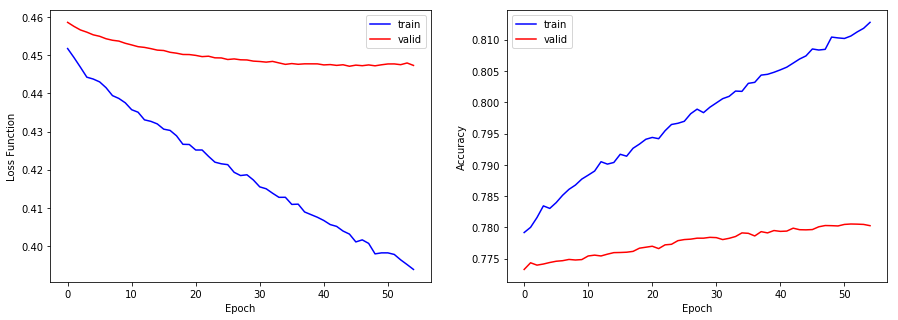

In [10]:
history(fit)

The best model, i.e, the one with the lowest value of the loss function calculated on the validation data, is loaded. Predictions are made on the test data and the $F_1$ score is then calculated.

In [11]:
model.load_weights('data/saved_models/weights_finetune_resnet50.hdf5')

In [12]:
predictions = (model.predict(test_tensors) >= 0.5).astype(int)

In [13]:
model_score = f1_score(test_targets[:nb_test], predictions)
print('F1 score: %.5f' % model_score)

F1 score: 0.78925
